## In this notebook we prepare the data for further usage with LLM models


#

### Install dependencies

In [ ]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm bs4 pypdf 

In [ ]:
!wget -r -A.html -P langchain-api https://api.python.langchain.com/en/latest/

In [105]:
from langchain.document_loaders import ReadTheDocsLoader
from langchain.document_loaders import PyPDFLoader


def load_documents(loader: object):
    docs = loader.load()
    return docs

In [106]:

loader = ReadTheDocsLoader('langchain-api')
langchain_api_docs = load_documents(loader)


/Users/vladfeigin/myprojects/openai/workshops/dataai/vlad-cognitive-search-openai/cognitive_search_openai/.venv/lib/python3.10/site-packages/langchain/document_loaders/readthedocs.py:75: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 75 of the file /Users/vladfeigin/myprojects/openai/workshops/dataai/vlad-cognitive-search-openai/cognitive_search_openai/.venv/lib/python3.10/site-packages/langchain/document_loaders/readthedocs.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(data, **self.bs_kwargs)


In [108]:
len(langchain_api_docs)

2152

In [111]:
print(langchain_api_docs[5].metadata)
print(langchain_api_docs[5].page_content)

{'source': 'langchain-api/api.python.langchain.com/en/latest/retrievers/langchain.retrievers.svm.SVMRetriever.html'}
langchain.retrievers.svm.SVMRetriever¶
class langchain.retrievers.svm.SVMRetriever[source]¶
Bases: BaseRetriever
SVM Retriever.
Largely based on
https://github.com/karpathy/randomfun/blob/master/knn_vs_svm.ipynb
Create a new model by parsing and validating input data from keyword arguments.
Raises ValidationError if the input data cannot be parsed to form a valid model.
param embeddings: Embeddings [Required]¶
Embeddings model to use.
param index: Any = None¶
Index of embeddings.
param k: int = 4¶
Number of results to return.
param metadata: Optional[Dict[str, Any]] = None¶
Optional metadata associated with the retriever. Defaults to None
This metadata will be associated with each call to this retriever,
and passed as arguments to the handlers defined in callbacks.
You can use these to eg identify a specific instance of a retriever with its
use case.
param relevancy_thre

In [107]:
loader = PyPDFLoader("semantic-kernel.pdf")
sk_docs = load_documents(loader)

In [112]:
print(sk_docs[5].metadata)
print(sk_docs[5].page_content)

{'source': 'semantic-kernel.pdf', 'page': 5}
Given that new breakthroughs in LLM AIs are landing on a daily basis, you should expect
this SDK evolve. W e're excited to see what you build with Semantic K ernel and we look
forward to your feedback and contributions so we can build the best practices together
in the SDK.
We welcome contributions and suggestions from the Semantic K ernel community! One
of the easiest ways to participate is to engage in discussions in the GitHub repository .
Bug reports and fixes are welcome!
For new features, components, or extensions, please open an issue  and discuss with us
before sending a PR. This will help avoid rejections since it will allow us to discuss the
impact to the larger ecosystem.
Now that you know what Semantic K ernel is, follow the get started  link to try it out.
Within minutes you can create prompts and chain them with out-of-the-box plugins
and native code. Soon afterwards, you can give your apps memories with embeddings
and summon e

In [113]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [ ]:
tiktoken.encoding_for_model('gpt-3.5-turbo')

In [116]:
tiktoken.encoding_for_model('gpt-4')

<Encoding 'cl100k_base'>

In [118]:
tokens_per_doc_in_sk = [tiktoken_len(doc.page_content) for doc in sk_docs]
print (f"max tokens in a document: {max(tokens_per_doc_in_sk)}")

max tokens in a document: 702


In [121]:
tokens_per_doc_in_lc_api = [tiktoken_len(doc.page_content) for doc in langchain_api_docs]
print (f"max tokens in a document: {max(tokens_per_doc_in_lc_api)}")

max tokens in a document: 28854


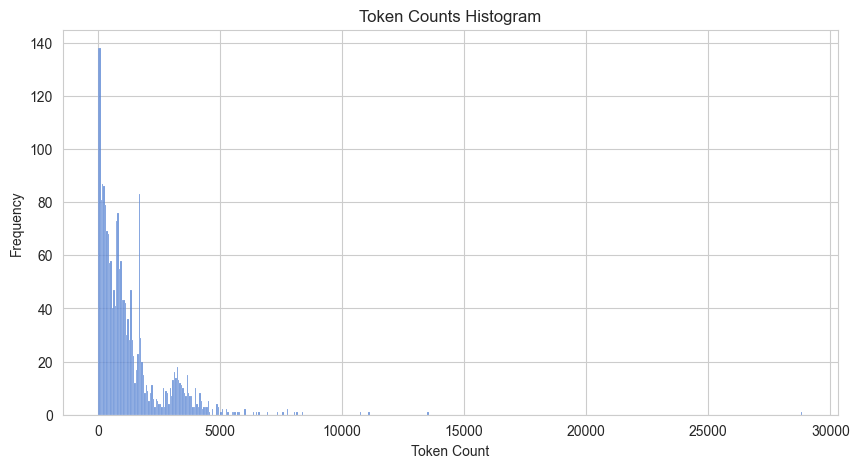

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# create histogram
plt.figure(figsize=(10, 5))
sns.histplot(tokens_per_doc_in_lc_api, kde=False, bins=500)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

In [150]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [151]:
from tqdm.auto import tqdm
from  langchain.schema.document import Document
import hashlib
import json
m = hashlib.md5()

In [152]:

def prepare_data_for_embedding(docs: list[Document]):
  documents = []

  for doc in tqdm(docs):
      url = doc.metadata['source']
      m.update(url.encode('utf-8'))
      uid = m.hexdigest()[:12]
      chunks = text_splitter.split_text(doc.page_content)
      for i, chunk in enumerate(chunks):
         documents.append({
          'id': f'{uid}-{i}',
          'text': chunk,
          'source': url,  
        })
  return documents

In [153]:

def persist_docs(docs: list[str], target_path: str):
    with open(target_path, 'w') as f:
        for doc in docs:
            f.write(json.dumps(doc) + '\n')

In [155]:
persist_docs(prepare_data_for_embedding(sk_docs), "../data/semantic_kernel.jsonl")
persist_docs(prepare_data_for_embedding(langchain_api_docs), "../data/langchain.jsonl")



100%|██████████| 2152/2152 [00:05<00:00, 396.08it/s]
